### Using NLP to Analyze Drug Reviews from Druglib.com

In [1]:
# https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Druglib.com%29

In [2]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [3]:
# https://stackabuse.com/python-for-nlp-topic-modeling/

## Step by Step NLP Analysis

In [4]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import string, re
from wordcloud import WordCloud

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [5]:
d_text = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
print(len(d_text))
d_text.head(4)

3107


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...


### Text EDA

In [6]:
len(d_text)

3107

In [7]:
d_text.head(4)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...


In [8]:
d_text['effectiveness'].value_counts()

Highly Effective          1330
Considerably Effective     928
Moderately Effective       415
Ineffective                247
Marginally Effective       187
Name: effectiveness, dtype: int64

In [9]:
d_text['sideEffects'].value_counts()

Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: sideEffects, dtype: int64

In [10]:
d_text['rating'].value_counts()

10    742
8     558
9     480
7     350
1     305
5     159
6     157
3     146
4     107
2     103
Name: rating, dtype: int64

In [11]:
d_text['condition'].value_counts()

depression                                236
acne                                      165
anxiety                                    63
insomnia                                   54
birth control                              49
                                         ... 
severe upper respitory tract infection      1
addh                                        1
panic attacks, depression                   1
acic reflux                                 1
anxiety, panic disorder                     1
Name: condition, Length: 1426, dtype: int64

In [12]:
d_text['benefitsReview']

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

In [13]:
review = d_text['benefitsReview']
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

### Text Formatting

#### Tokenizing

Do this for each Review column

In [14]:
tokenized_review = review.apply(nltk.word_tokenize)
tokenized_review.head(3)

0    [slowed, the, progression, of, left, ventricul...
1    [Although, this, type, of, birth, control, has...
2    [I, was, used, to, having, cramps, so, badly, ...
Name: benefitsReview, dtype: object

In [15]:
print(tokenized_review)

0       [slowed, the, progression, of, left, ventricul...
1       [Although, this, type, of, birth, control, has...
2       [I, was, used, to, having, cramps, so, badly, ...
3       [The, acid, reflux, went, away, for, a, few, m...
4       [I, think, that, the, Lyrica, was, starting, t...
                              ...                        
3102    [Increased, focus, ,, attention, ,, productivi...
3103    [Emotions, were, somewhat, blunted, ., Less, m...
3104                                              [--, -]
3105          [Controlled, complex, partial, seizures, .]
3106    [The, drug, Micardis, did, seem, to, alleviate...
Name: benefitsReview, Length: 3107, dtype: object


In [16]:
total_words = []
for sentence in tokenized_review:
    for word in sentence:
        total_words.append(word)

In [17]:
fdist = FreqDist(total_words)
print(fdist)

<FreqDist with 9540 samples and 126845 outcomes>


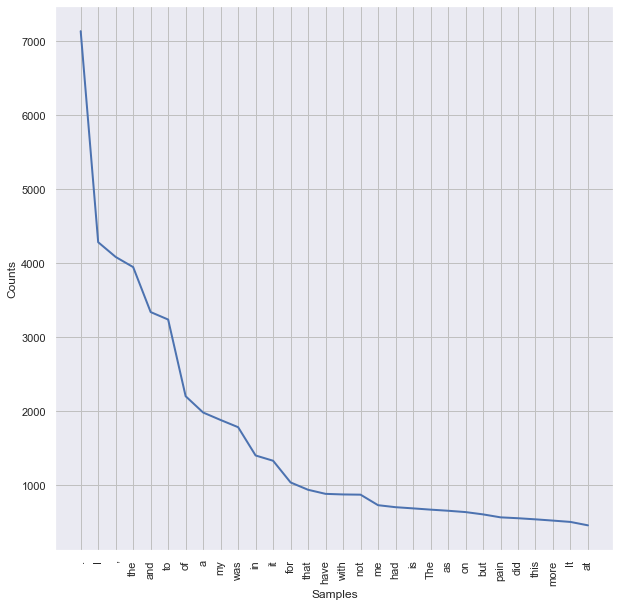

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
plt.figure(figsize=(10,10))
fdist.plot(30)

#### Removing Stop Words

In [19]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'me', 'why', 'doesn', 'haven', 'again', 'herself', 'after', 'between', 'what', 'or', 'our', 'mustn', 'over', 're', 'but', 'a', 'on', 'y', 'is', 'now', 'once', 'had', 'as', 'it', 'under', "couldn't", 'and', 'you', 'wasn', 'both', 'myself', 'any', 'needn', 'been', "you'll", 'just', 'against', 'below', 'this', 'all', 'itself', 'more', 'few', 'her', "that'll", 'then', "aren't", 'couldn', "it's", 'some', 'very', "doesn't", "didn't", "won't", 'll', 'through', 'before', 'its', 'in', 'where', 'we', 'because', 'into', 'own', "haven't", 'being', 'shouldn', 'ain', 'hadn', 'has', 'hasn', "shan't", "you're", 'same', 'shan', 'was', 'o', 'up', 'didn', 'yours', 'most', 'don', 'ours', 'who', 'should', 's', 'there', 'too', 'he', 'she', 'd', 'their', 'at', 'aren', 'yourselves', 'how', 'while', 'isn', 'ourselves', 'further', 'each', 'for', 'so', 'does', 'no', "isn't", 'of', 'nor', 'other', 'ma', 'himself', 'them', 'by', 'won', "wasn't", 've', "hasn't", 'not', 'out', 'mightn', 'm', "hadn't", 'these', 'him

In [20]:
filtered_review=[]
for w in total_words:
    if w not in stop_words:
        filtered_review.append(w)
print("Filterd Words:",filtered_review[:20])

Filterd Words: ['slowed', 'progression', 'left', 'ventricular', 'dysfunction', 'overt', 'heart', 'failure', 'alone', 'agents', 'managment', 'hypertension', 'mangagement', 'congestive', 'heart', 'failur', 'Although', 'type', 'birth', 'control']


In [21]:
print(len(total_words))
print(len(filtered_review))

126845
82365


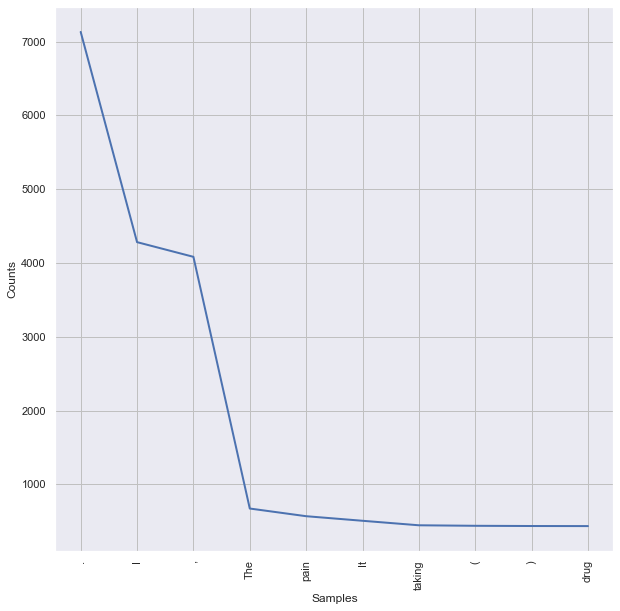

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [22]:
fdist = FreqDist(filtered_review)
plt.figure(figsize=(10,10))
fdist.plot(10)

Why are words like The, It, -, (, ) appearing above?

#### Stemming

In [23]:
ps = PorterStemmer()

stemmed_review=[]
for w in filtered_review:
    stemmed_review.append(ps.stem(w))

# print(stemmed_review)

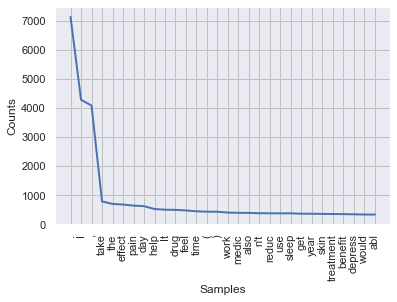

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
fdist = FreqDist(stemmed_review)
fdist.plot(30)

#### Lemmatiziation

In [25]:
lemmatizer = WordNetLemmatizer() 

In [26]:
print("movies:", lemmatizer.lemmatize("movies")) 
print("collecting:", lemmatizer.lemmatize("collecting")) 
print("collection:", lemmatizer.lemmatize("collection")) 
print("collections:", lemmatizer.lemmatize("collections")) 

movies: movie
collecting: collecting
collection: collection
collections: collection


In [27]:
# comparing it with stemming 
print("movies:", ps.stem("movies")) 
print("collecting :", ps.stem("collecting")) 

movies: movi
collecting : collect


In [28]:
# we can also lemmatize our original reviews
lemmatized_review=[]
for w in filtered_review:
    lemmatized_review.append(lemmatizer.lemmatize(w))

# print(lemmatized_review)

### Feature Engineering for NLP

#### Vectorizing

In [29]:
# Convert a collection of text documents to a matrix of token counts
docs = review
vec = CountVectorizer(stop_words=None)
X = vec.fit_transform(docs)

df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df

,00,000,02,05,09,10,100,1000,100mg,101,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

In [31]:
# vec.get_feature_names()

#### TF-IDF

In [32]:
# term frequency-inverse document frequency 
# Essentially, tf-idf normalizes the raw count of the document term matrix 
# And it represents how important a word is in the given document

In [33]:
# using count vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(review)

In [34]:
type(text_counts)

scipy.sparse.csr.csr_matrix

In [35]:
pd.DataFrame(text_counts)

,0
0,"(0, 6017)\t1\n (0, 5108)\t1\n (0, 3769)\t1..."
1,"(0, 6895)\t1\n (0, 912)\t1\n (0, 1568)\t1\..."
2,"(0, 1651)\t1\n (0, 7030)\t1\n (0, 3068)\t1..."
3,"(0, 1942)\t1\n (0, 1763)\t1\n (0, 6529)\t2..."
4,"(0, 3108)\t1\n (0, 4680)\t1\n (0, 3644)\t1..."
...,...
3102,"(0, 2237)\t1\n (0, 5867)\t1\n (0, 4250)\t1..."
3103,"(0, 6089)\t1\n (0, 2283)\t1\n (0, 4251)\t1..."
3104,
3105,"(0, 1574)\t1\n (0, 5820)\t1\n (0, 4724)\t1..."


In [36]:
df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())
df

,0,00,000,02,05,09,1,10,100,1000,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df.columns

Index(['0', '00', '000', '02', '05', '09', '1', '10', '100', '1000',
       ...
       'zone', 'zoning', 'zoster', 'zovirax', 'zpak', 'zyban', 'zydol',
       'zyprexa', 'zyrtec', 'zyvox'],
      dtype='object', length=7421)

In [38]:
# using tfidf vectorizer instead

In [39]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(review)
text_tf.data

array([0.26653355, 0.24440442, 0.26653355, ..., 0.09047276, 0.07477417,
       0.07082331])

In [40]:
# examine what type of object text_tf is
print(type(text_tf))
print(type(text_tf.data))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


In [41]:
def fn_tdm_df(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    vectorizer = CountVectorizer(**kwargs)
    x1 = vectorizer.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = vectorizer.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df



In [42]:
fn_tdm_df(review).T

,00,000,02,05,09,10,100,1000,100mg,101,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
def fn_tdm_tfidf(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    tf = TfidfVectorizer(**kwargs)
    x1 = tf.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = tf.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df

In [44]:
fn_tdm_tfidf(review).transpose()

,00,000,02,05,09,10,100,1000,100mg,101,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Text Classification

Using patients' drug and treatment reviews to predict effectiveness of treatment

#### Preprocessing and Cleaning

In [45]:
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

**Formatting the data for classification based on effective vs not effective**

In [46]:
d_text['effectiveness'].value_counts(normalize=True)

Highly Effective          0.428066
Considerably Effective    0.298680
Moderately Effective      0.133569
Ineffective               0.079498
Marginally Effective      0.060187
Name: effectiveness, dtype: float64

In [47]:
d_text['effectiveness'].replace('Highly Effective', 'Effective', inplace=True)
d_text['effectiveness'].replace('Considerably Effective', 'Effective', inplace=True)
d_text['effectiveness'].replace('Moderately Effective', 'Effective', inplace=True)
d_text['effectiveness'].replace('Ineffective', 'Not Effective', inplace=True)
d_text['effectiveness'].replace('Marginally Effective', 'Not Effective', inplace=True)

In [48]:
d_text['effectiveness'].value_counts(normalize=True)

Effective        0.860315
Not Effective    0.139685
Name: effectiveness, dtype: float64

In [49]:
d_text['effectiveness'].replace('Effective', 1, inplace=True)
d_text['effectiveness'].replace('Not Effective', 0, inplace=True)

In [50]:
d_text['effectiveness'].value_counts()

1    2673
0     434
Name: effectiveness, dtype: int64

In [51]:
target = d_text['effectiveness']
data = review

#### Text Formatting

In [52]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [53]:
## setting stopwords and punctuations

#### need to format this for specific corpus working with

sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com', '-', '–', '—']
sw_set = set(sw_list)

In [54]:
# we can define a function that removes stopwords 
def process_text(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed 

In [55]:
processed_text = list(map(process_text, data))

In [56]:
# processed_text

In [57]:
total_vocab = set()
for comment in processed_text:
    total_vocab.update(comment)
len(total_vocab)

8111

In [58]:
# creating a list with all lemmatized outputs
lemmatized_output = []

for listy in processed_text:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [59]:
X_lem = lemmatized_output
[' '.join(d) for d in processed_text]

y_lem = target
X[3]

<1x7664 sparse matrix of type '<class 'numpy.int64'>'
	with 67 stored elements in Compressed Sparse Row format>

### Corpus Statistics and EDA

In [60]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<2485x6385 sparse matrix of type '<class 'numpy.float64'>'
	with 43543 stored elements in Compressed Sparse Row format>

In [61]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Review: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Review: 17.522334004024145
Percentage of columns containing ZERO: 0.9972557033666368


#### Most Frequent Words

In [62]:
# target = d_text['effectiveness']
# data = review

df = d_text.copy(deep=True)

In [63]:
df_freq_effective = df[df['effectiveness']==1]
df_freq_not_effective = df[df['effectiveness']==0]

In [64]:
data_eff = df_freq_effective['benefitsReview']
data_not_eff = df_freq_not_effective['benefitsReview']

In [65]:
pros_effective = list(map(process_text, data_eff))
pros_not_effective = list(map(process_text, data_not_eff))

In [66]:
total_vocab_eff = set()
for comment in pros_effective:
    total_vocab_eff.update(comment)
len(total_vocab_eff)

7649

In [67]:
total_vocab_NOT_eff = set()
for comment in pros_not_effective:
    total_vocab_NOT_eff.update(comment)
len(total_vocab_NOT_eff)

1990

In [68]:
print(pros_effective[:2])

[['slowed', 'progression', 'left', 'ventricular', 'dysfunction', 'overt', 'heart', 'failure', 'alone', 'agents', 'managment', 'hypertension', 'mangagement', 'congestive', 'heart', 'failur'], ['although', 'type', 'birth', 'control', 'cons', 'pros', 'help', 'cramps', "'s", 'also', 'effective', 'prevention', 'pregnancy', 'along', 'use', 'condoms', 'well']]


In [69]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_effective = [item for sublist in pros_effective for item in sublist]
flat_not_effective = [item for sublist in pros_not_effective for item in sublist]

In [70]:
effective_freq = FreqDist(flat_effective)
not_effective_freq = FreqDist(flat_not_effective)

In [71]:
# Top 20 satire words:

effective_freq.most_common(20)

[('pain', 532),
 ('taking', 422),
 ('drug', 378),
 ('also', 374),
 ('day', 355),
 ('sleep', 327),
 ('able', 326),
 ('skin', 322),
 ("n't", 320),
 ('would', 301),
 ('better', 301),
 ('time', 301),
 ('medication', 295),
 ('treatment', 276),
 ('take', 274),
 ('much', 269),
 ('symptoms', 260),
 ('feel', 260),
 ('less', 258),
 ('depression', 256)]

In [72]:
# Top 20 non-satire words:

not_effective_freq.most_common(20)

[('benefits', 91),
 ('none', 90),
 ("n't", 65),
 ('treatment', 63),
 ('drug', 61),
 ('pain', 60),
 ('effects', 57),
 ('side', 55),
 ('taking', 47),
 ('would', 38),
 ('skin', 38),
 ('medication', 37),
 ('still', 34),
 ('benefit', 32),
 ('acne', 31),
 ('time', 31),
 ('doctor', 30),
 ('help', 30),
 ('better', 30),
 ('could', 28)]

In [73]:
## need to fix the " n't "

#### Normalized Word Frequencies:

In [74]:
review_total_word_count = sum(effective_freq.values())
review_top_25 = effective_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in review_top_25:
    normalized_frequency = word[1]/review_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

pain 		 0.009611
taking 		 0.007624
drug 		 0.006829
also 		 0.006757
day 		 0.006413
sleep 		 0.005908
able 		 0.00589
skin 		 0.005817
n't 		 0.005781
would 		 0.005438
better 		 0.005438
time 		 0.005438
medication 		 0.00533
treatment 		 0.004986
take 		 0.00495
much 		 0.00486
symptoms 		 0.004697
feel 		 0.004697
less 		 0.004661
depression 		 0.004625
effects 		 0.004625
get 		 0.004571
helped 		 0.004535
reduced 		 0.004444
years 		 0.00439


In [75]:
not_effective_total_word_count = sum(not_effective_freq.values())
not_effective_top_25 = not_effective_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in not_effective_top_25:
    normalized_frequency = word[1]/not_effective_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

benefits 		 0.01547
none 		 0.0153
n't 		 0.01105
treatment 		 0.01071
drug 		 0.01037
pain 		 0.0102
effects 		 0.009687
side 		 0.009347
taking 		 0.007988
would 		 0.006458
skin 		 0.006458
medication 		 0.006288
still 		 0.005778
benefit 		 0.005438
acne 		 0.005269
time 		 0.005269
doctor 		 0.005099
help 		 0.005099
better 		 0.005099
could 		 0.004759
helped 		 0.004759
severe 		 0.004589
improvement 		 0.004589
get 		 0.004419
took 		 0.004419


#### Visualizing the Text

In [76]:
# create counts of effective and not effective with values and words
effective_bar_counts = [x[1] for x in effective_freq.most_common(25)]
effective_bar_words = [x[0] for x in effective_freq.most_common(25)]

not_effective_bar_counts = [x[1] for x in not_effective_freq.most_common(25)]
not_effective_bar_words = [x[0] for x in not_effective_freq.most_common(25)]

In [77]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

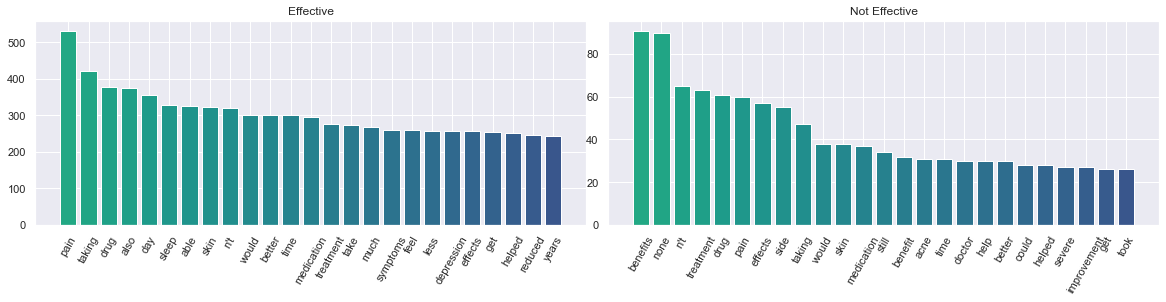

In [78]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(effective_bar_words, effective_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(not_effective_bar_words, not_effective_bar_counts, color=color )

ax.title.set_text('Effective')
ax2.title.set_text('Not Effective')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

#### Word Clouds

In [79]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))

effective_dictionary = dict(zip(effective_bar_words, effective_bar_counts))
not_effective_dictionary = dict(zip(not_effective_bar_words, not_effective_bar_counts))

In [80]:
effective_dictionary

{'pain': 532,
 'taking': 422,
 'drug': 378,
 'also': 374,
 'day': 355,
 'sleep': 327,
 'able': 326,
 'skin': 322,
 "n't": 320,
 'would': 301,
 'better': 301,
 'time': 301,
 'medication': 295,
 'treatment': 276,
 'take': 274,
 'much': 269,
 'symptoms': 260,
 'feel': 260,
 'less': 258,
 'depression': 256,
 'effects': 256,
 'get': 253,
 'helped': 251,
 'reduced': 246,
 'years': 243}

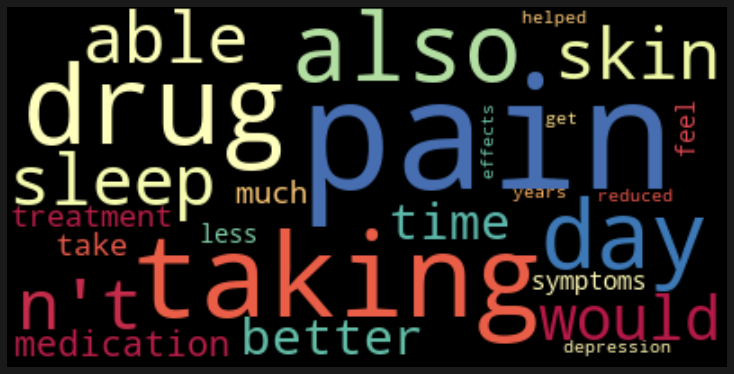

In [81]:
# creating a word cloud

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(effective_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

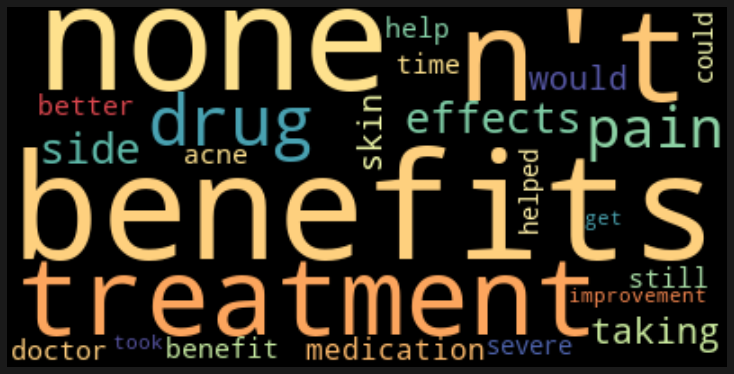

In [82]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_effective_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

### Classification

Using a Random Forest classifier

In [83]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=5)

In [84]:
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [85]:
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8955

F1 Score: 0.9416


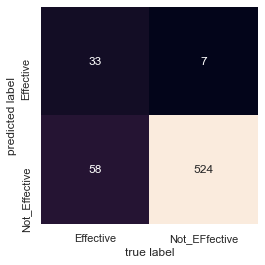

In [86]:
mat = confusion_matrix(y_test_lem, rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Effective', 'Not_EFfective'], yticklabels=['Effective', 'Not_Effective'])
plt.xlabel('true label')
plt.ylabel('predicted label');

Using a Gradient Boost classifier

In [87]:
gb_classifier_lem = GradientBoostingClassifier(n_estimators=100, learning_rate=.7, 
    max_depth=5, min_samples_leaf=5, random_state=6)

In [88]:
gb_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

gb_test_preds_lem = gb_classifier_lem.predict(tfidf_data_test_lem)

In [89]:
gb_acc_score_lem = accuracy_score(y_test_lem, gb_test_preds_lem)
gb_f1_score_lem = f1_score(y_test_lem, gb_test_preds_lem)
print('Gradient Boost with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(gb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(gb_f1_score_lem))

Gradient Boost with Lemmatization Features
Testing Accuracy: 0.8553

F1 Score: 0.9167


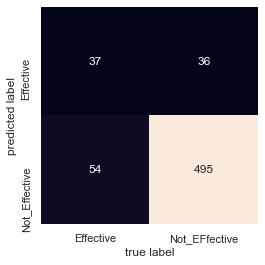

In [90]:
mat = confusion_matrix(y_test_lem, gb_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Effective', 'Not_EFfective'], yticklabels=['Effective', 'Not_Effective'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [91]:
probs = gb_classifier_lem.predict_proba(tfidf_data_test_lem)
probs

array([[0.02565148, 0.97434852],
       [0.02565148, 0.97434852],
       [0.02565148, 0.97434852],
       ...,
       [0.02565148, 0.97434852],
       [0.02565148, 0.97434852],
       [0.02565148, 0.97434852]])

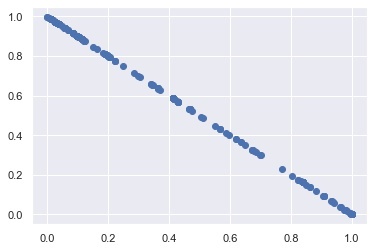

In [92]:
plt.scatter(probs[:,0], probs[:,1])
plt.show()

## Preparing and Predicting on the Test Dataset

In [93]:
# import the test dataset
# isolate the target and body columns
# clean and transform the body column
# transform the target column to 1 and 0
# train and predict
# evaluate

### Formatting Target

In [94]:
d_text = pd.read_csv('drugLibTest_raw.tsv', sep='\t')
print(len(d_text))
d_text.head(4)

1036


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...
3,969,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...


In [95]:
review = d_text['benefitsReview']

In [96]:
d_text['effectiveness'].value_counts(normalize=True)

Highly Effective          0.396718
Considerably Effective    0.299228
Moderately Effective      0.151544
Ineffective               0.079151
Marginally Effective      0.073359
Name: effectiveness, dtype: float64

In [97]:
d_text['effectiveness'].replace('Highly Effective', 'Effective', inplace=True)
d_text['effectiveness'].replace('Considerably Effective', 'Effective', inplace=True)
d_text['effectiveness'].replace('Moderately Effective', 'Effective', inplace=True)
d_text['effectiveness'].replace('Ineffective', 'Not Effective', inplace=True)
d_text['effectiveness'].replace('Marginally Effective', 'Not Effective', inplace=True)

In [98]:
d_text['effectiveness'].value_counts(normalize=True)

Effective        0.84749
Not Effective    0.15251
Name: effectiveness, dtype: float64

In [99]:
d_text['effectiveness'].replace('Effective', 1, inplace=True)
d_text['effectiveness'].replace('Not Effective', 0, inplace=True)

In [100]:
d_text['effectiveness'].value_counts()

1    878
0    158
Name: effectiveness, dtype: int64

In [101]:
target = d_text['effectiveness']
data = review

### Formatting Body

In [102]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [103]:
## setting stopwords and punctuations

#### need to format this for specific corpus working with

sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com', '-', '–', '—']
sw_set = set(sw_list)

In [104]:
# we can define a function that removes stopwords 
def process_text(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed 

In [105]:
processed_text = list(map(process_text, data))

In [106]:
# processed_text

In [107]:
total_vocab = set()
for comment in processed_text:
    total_vocab.update(comment)
len(total_vocab)

4448

In [108]:
# creating a list with all lemmatized outputs
lemmatized_output = []

for listy in processed_text:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [109]:
X_lem = lemmatized_output
[' '.join(d) for d in processed_text]

y_lem = target
X[3]

<1x7664 sparse matrix of type '<class 'numpy.int64'>'
	with 67 stored elements in Compressed Sparse Row format>

### Splitting Data for Classification

In [110]:
# X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)

tfidf_data_test_lem = tfidf.transform(X_lem)

tfidf_data_test_lem

<1036x6385 sparse matrix of type '<class 'numpy.float64'>'
	with 16712 stored elements in Compressed Sparse Row format>

In [111]:
non_zero_cols = tfidf_data_test_lem.nnz / float(tfidf_data_test_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Review: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_test_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Review: 16.131274131274132
Percentage of columns containing ZERO: 0.9974735670898552


### Testing and Evaluation on the Trained Model

#### Using a Random Forest classifier

In [112]:
rf_testing_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [113]:
rf_acc_score_lem = accuracy_score(y_lem, rf_testing_preds_lem)
rf_f1_score_lem = f1_score(y_lem, rf_testing_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8813

F1 Score: 0.9333


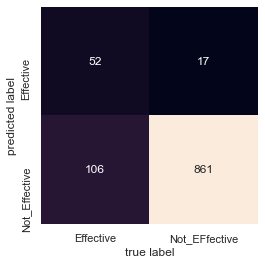

In [114]:
mat = confusion_matrix(y_lem, rf_testing_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Effective', 'Not_EFfective'], yticklabels=['Effective', 'Not_Effective'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [115]:
probs = rf_classifier_lem.predict_proba(tfidf_data_test_lem)
probs

array([[0.24, 0.76],
       [0.01, 0.99],
       [0.06, 0.94],
       ...,
       [0.17, 0.83],
       [0.12, 0.88],
       [0.13, 0.87]])

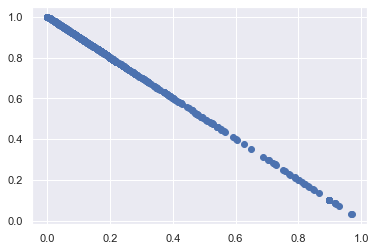

In [116]:
plt.scatter(probs[:,0], probs[:,1])
plt.show()

#### Using a Gradient Boost classifier

In [117]:
gb_testing_preds_lem = gb_classifier_lem.predict(tfidf_data_test_lem)

In [118]:
gb_acc_score_lem = accuracy_score(y_lem, gb_testing_preds_lem)
gb_f1_score_lem = f1_score(y_lem, gb_testing_preds_lem)
print('Gradient Boost with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(gb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(gb_f1_score_lem))

Gradient Boost with Lemmatization Features
Testing Accuracy: 0.862

F1 Score: 0.9201


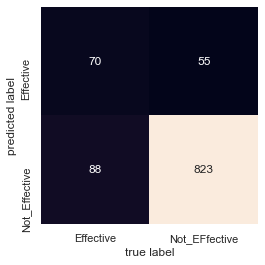

In [119]:
mat = confusion_matrix(y_lem, gb_testing_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Effective', 'Not_EFfective'], yticklabels=['Effective', 'Not_Effective'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [120]:
probs = gb_classifier_lem.predict_proba(tfidf_data_test_lem)
probs

array([[0.19568886, 0.80431114],
       [0.02565148, 0.97434852],
       [0.04022132, 0.95977868],
       ...,
       [0.02565148, 0.97434852],
       [0.30483206, 0.69516794],
       [0.02565148, 0.97434852]])

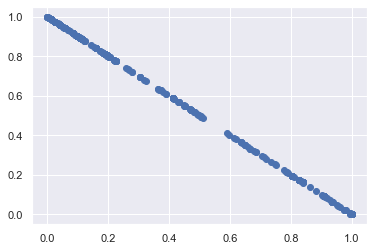

In [121]:
plt.scatter(probs[:,0], probs[:,1])
plt.show()

### Visualizing Test Data

In [122]:
non_zero_cols = tfidf_data_test_lem.nnz / float(tfidf_data_test_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Review: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_test_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Review: 16.131274131274132
Percentage of columns containing ZERO: 0.9974735670898552


#### Most Frequent Words

In [123]:
# target = d_text['effectiveness']
# data = review

df = d_text.copy(deep=True)

In [124]:
df_freq_effective = df[df['effectiveness']==1]
df_freq_not_effective = df[df['effectiveness']==0]

In [125]:
data_eff = df_freq_effective['benefitsReview']
data_not_eff = df_freq_not_effective['benefitsReview']

In [126]:
pros_effective = list(map(process_text, data_eff))
pros_not_effective = list(map(process_text, data_not_eff))

In [127]:
total_vocab_eff = set()
for comment in pros_effective:
    total_vocab_eff.update(comment)
len(total_vocab_eff)

4137

In [128]:
total_vocab_NOT_eff = set()
for comment in pros_not_effective:
    total_vocab_NOT_eff.update(comment)
len(total_vocab_NOT_eff)

1091

In [129]:
print(pros_effective[:2])

[['antibiotic', 'may', 'destroyed', 'bacteria', 'causing', 'sinus', 'infection', 'may', 'also', 'caused', 'virus', 'hard', 'say'], ['lamictal', 'stabilized', 'serious', 'mood', 'swings', 'minute', 'clawing', 'walls', 'pure', 'mania', 'next', 'curled', 'fetal', 'position', 'bed', 'contemplating', 'suicdie', 'longer', 'whim', 'moods', 'neither', 'around', "'m", 'lucky', 'started', 'pharmaceuticals', 'almost', 'immediately', 'diagnosed', 'bipolar', 'lamictal', 'gives', 'amazing', 'clarity', 'go', 'day', 'honestly', 'assess', 'form', 'real', 'relationships', 'lamitcal', 'lifted', 'fog', 'guess', 'could', 'call', "'m", 'medicated', 'realize', 'cloudy', 'thought', 'processes', 'used', "'s", 'wonderful', 'feeling', 'interestingly', 'hardly', 'dreamt', 'beginning', 'lamictal', 'would', 'dream', 'mean', 'dream', 'sense', 'able', 'imagine', 'pictures', 'scenes', 'asleep', 'rem', 'maybe', 'every', 'two', 'months', 'dream', 'every', 'night', 'found', 'closer', 'take', 'bedtime', 'frequent', 'inten

In [130]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_effective = [item for sublist in pros_effective for item in sublist]
flat_not_effective = [item for sublist in pros_not_effective for item in sublist]

In [131]:
effective_freq = FreqDist(flat_effective)
not_effective_freq = FreqDist(flat_not_effective)

In [132]:
# Top 20 satire words:

effective_freq.most_common(20)

[('pain', 157),
 ('taking', 145),
 ('skin', 124),
 ('would', 123),
 ('drug', 115),
 ("n't", 114),
 ('also', 111),
 ('take', 111),
 ('day', 109),
 ('better', 109),
 ('able', 106),
 ('sleep', 106),
 ('much', 101),
 ('reduced', 98),
 ('acne', 95),
 ('helped', 89),
 ('less', 85),
 ('like', 83),
 ('effects', 80),
 ('treatment', 78)]

In [133]:
# Top 20 non-satire words:

not_effective_freq.most_common(20)

[('benefits', 34),
 ('none', 33),
 ('treatment', 22),
 ('pain', 22),
 ('effects', 20),
 ('take', 20),
 ('medication', 19),
 ('taking', 19),
 ('drug', 18),
 ('felt', 15),
 ("n't", 15),
 ('side', 15),
 ('help', 14),
 ('would', 14),
 ('see', 13),
 ('took', 12),
 ('time', 12),
 ('days', 12),
 ('helped', 12),
 ('benefit', 11)]

In [134]:
## need to fix the " n't "

#### Normalized Word Frequencies:

In [135]:
review_total_word_count = sum(effective_freq.values())
review_top_25 = effective_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in review_top_25:
    normalized_frequency = word[1]/review_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

pain 		 0.008507
taking 		 0.007857
skin 		 0.006719
would 		 0.006665
drug 		 0.006231
n't 		 0.006177
also 		 0.006015
take 		 0.006015
day 		 0.005906
better 		 0.005906
able 		 0.005744
sleep 		 0.005744
much 		 0.005473
reduced 		 0.00531
acne 		 0.005148
helped 		 0.004823
less 		 0.004606
like 		 0.004497
effects 		 0.004335
treatment 		 0.004226
medication 		 0.004226
months 		 0.004172
feel 		 0.004172
days 		 0.004172
time 		 0.004172


In [136]:
not_effective_total_word_count = sum(not_effective_freq.values())
not_effective_top_25 = not_effective_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in not_effective_top_25:
    normalized_frequency = word[1]/not_effective_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

benefits 		 0.01515
none 		 0.01471
treatment 		 0.009804
pain 		 0.009804
effects 		 0.008913
take 		 0.008913
medication 		 0.008467
taking 		 0.008467
drug 		 0.008021
felt 		 0.006684
n't 		 0.006684
side 		 0.006684
help 		 0.006239
would 		 0.006239
see 		 0.005793
took 		 0.005348
time 		 0.005348
days 		 0.005348
helped 		 0.005348
benefit 		 0.004902
months 		 0.004902
day 		 0.004902
stop 		 0.004902
better 		 0.004456
prescribed 		 0.004456


#### Visualizing the Text

In [137]:
# create counts of effective and not effective with values and words
effective_bar_counts = [x[1] for x in effective_freq.most_common(25)]
effective_bar_words = [x[0] for x in effective_freq.most_common(25)]

not_effective_bar_counts = [x[1] for x in not_effective_freq.most_common(25)]
not_effective_bar_words = [x[0] for x in not_effective_freq.most_common(25)]

In [138]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

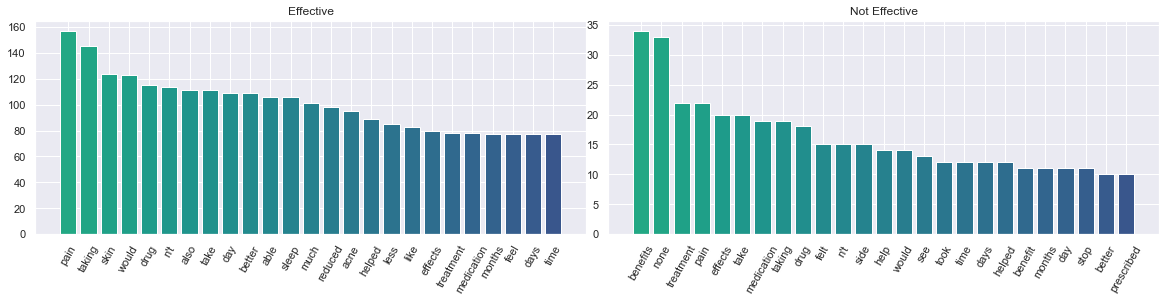

In [139]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(effective_bar_words, effective_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(not_effective_bar_words, not_effective_bar_counts, color=color )

ax.title.set_text('Effective')
ax2.title.set_text('Not Effective')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

#### Word Clouds

In [140]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))

effective_dictionary = dict(zip(effective_bar_words, effective_bar_counts))
not_effective_dictionary = dict(zip(not_effective_bar_words, not_effective_bar_counts))

In [141]:
effective_dictionary

{'pain': 157,
 'taking': 145,
 'skin': 124,
 'would': 123,
 'drug': 115,
 "n't": 114,
 'also': 111,
 'take': 111,
 'day': 109,
 'better': 109,
 'able': 106,
 'sleep': 106,
 'much': 101,
 'reduced': 98,
 'acne': 95,
 'helped': 89,
 'less': 85,
 'like': 83,
 'effects': 80,
 'treatment': 78,
 'medication': 78,
 'months': 77,
 'feel': 77,
 'days': 77,
 'time': 77}

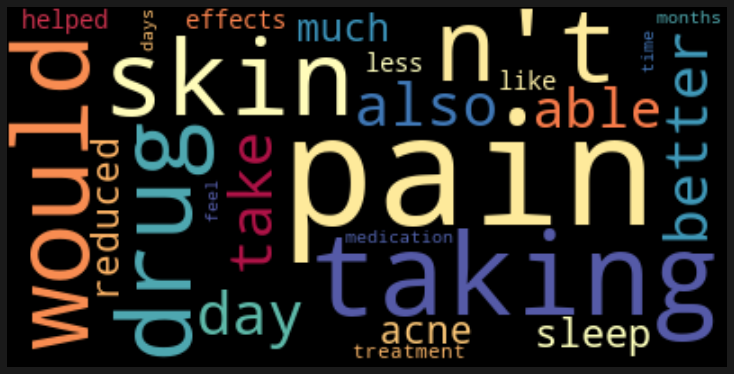

In [142]:
# creating a word cloud

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(effective_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

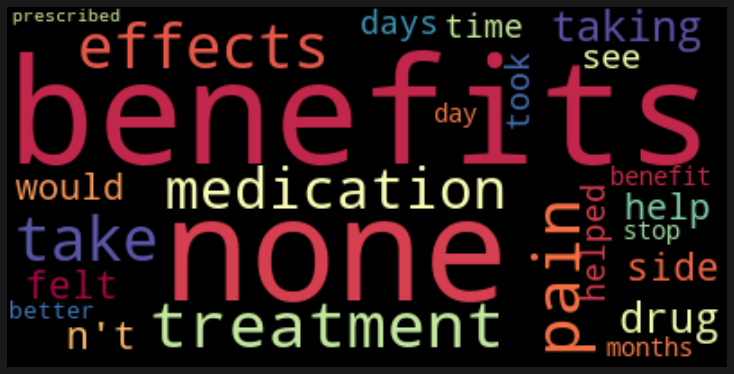

In [143]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_effective_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

## Using NLP to Predict Drug Effectiveness

Given patient comments on treatment, can we predict the effectiveness of the treatment/drug?

### Exploring the Text

* tokenize the words
* remove stop words
* lemmatize the text

### Processing the Text

* can create a matrix with a token for each word
* can use tf-idf with CountVectorizer of TfidVectorizer

### Text Classification

* change labels to 1 and 0
* remove stop words and punctuation
* lemmatize the text
* explore word statistics and frequency plots / word clouds
* use tfidf to transform the data
* Random Forest and GradientBoost results
    * Acc: .90 and F1: .94 
    * Acc: .86 and F1: .92
    * Baseline accuracy of guessing all as Effective: .86


### Predicting on the Test Data